We could also see how removing the nulls but including dietary information performs. Though its a slight change to the question we could still possibly get some improvements there.

Lastly, we could take our regression problem and turn it into a classifier. With this number of features and a discontinuous outcome, we might have better luck thinking of this as a classification problem. We could make it simpler still by instead of classifying on each possible value, group reviews to some decided high and low values.

__And that is your challenge.__

Transform this regression problem into a binary classifier and clean up the feature set. You can choose whether or not to include nutritional information, but try to cut your feature set down to the 30 most valuable features.

Good luck!

When you've finished that, also take a moment to think about bias. Is there anything in this dataset that makes you think it could be biased, perhaps extremely so?

There is. Several things in fact, but most glaringly is that we don't actually have a random sample. It could be, and probably is, that the people more likely to choose some kinds of recipes are more likely to give high reviews.

After all, people who eat chocolate might just be happier people.

In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import statsmodels.api as sm
from sklearn.svm import SVR, SVC
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse

np.random.seed(123)

In [2]:
raw_data = pd.read_csv('https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/epi_r.csv')

In [3]:
raw_data.head()

,title,rating,calories,protein,fat,sodium,#cakeweek,#wasteless,22-minute meals,3-ingredient recipes,...,yellow squash,yogurt,yonkers,yuca,zucchini,cookbooks,leftovers,snack,snack week,turkey
0,"Lentil, Apple, and Turkey Wrap",2.500,426.0,30.0,7.0,559.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,Boudin Blanc Terrine with Red Onion Confit,4.375,403.0,18.0,23.0,1439.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Potato and Fennel Soup Hodge,3.750,165.0,6.0,7.0,165.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Mahi-Mahi in Tomato Olive Sauce,5.000,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Spinach Noodle Casserole,3.125,547.0,20.0,32.0,452.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
raw_data.rating.describe()

count    20052.000000
mean         3.714467
std          1.340829
min          0.000000
25%          3.750000
50%          4.375000
75%          4.375000
max          5.000000
Name: rating, dtype: float64

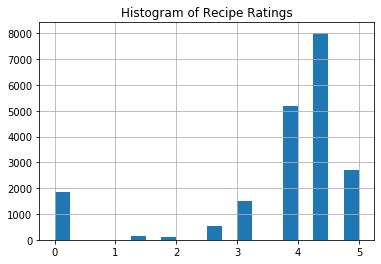

In [5]:
raw_data.rating.hist(bins=20)
plt.title('Histogram of Recipe Ratings')
plt.show()

In [6]:
# Count nulls 
null_count = raw_data.isnull().sum()
null_count[null_count>0]

calories    4117
protein     4162
fat         4183
sodium      4119
dtype: int64

In [7]:
raw_data = raw_data.drop(['calories', 'protein', 'fat', 'sodium'], 1)

In [8]:
print(raw_data.rating.mean())

3.714467384799521


In [9]:
print(raw_data.rating.median())

4.375


In [10]:
# drop 0's

#for index, row in raw_data.iterrows():
#    if row['rating'] == 0:
#        raw_data.drop(index, inplace=True)

## Selection Method 1: Correlation Matrix

In [11]:
# WARNING: SLOW

# method 1

corr_matrix = raw_data.corr()
print(corr_matrix['rating'].sort_values(ascending=False).head(30))

rating             1.000000
bon appétit        0.124549
peanut free        0.096087
soy free           0.092965
tree nut free      0.081347
bake               0.076978
roast              0.073499
fall               0.067343
sauté              0.066553
dinner             0.060957
kosher             0.059071
winter             0.055126
pescatarian        0.054034
thanksgiving       0.052990
onion              0.049997
grill/barbecue     0.048081
high fiber         0.047827
gourmet            0.047354
no sugar added     0.047197
tomato             0.046579
quick & easy       0.045216
herb               0.044253
pork               0.042463
beef               0.041550
cheese             0.041215
low carb           0.040738
mixer              0.040620
christmas          0.040595
sugar conscious    0.040573
braise             0.040155
Name: rating, dtype: float64


In [12]:
# compile features

features = ['rating', 'bon appétit', 'peanut free', 'soy free', 
            'tree nut free', 'bake', 'roast', 'fall', 'sauté', 
            'dinner', 'kosher', 'winter', 'pescatarian', 
            'thanksgiving', 'onion', 'grill/barbecue', 'high fiber', 
            'gourmet', 'no sugar added', 'tomato', 'quick & easy', 
            'herb', 'pork', 'beef', 'cheese', 'low carb', 'mixer', 
            'christmas', 'sugar conscious', 'braise']

In [13]:
raw_data_01 = raw_data.copy()

In [14]:
# convert scores to binary (median cutoff)

for index, row in raw_data_01.iterrows():
    if row['rating'] > raw_data_01.rating.median():
        raw_data_01.loc[index, 'rating'] = 1
    else:
        raw_data_01.loc[index, 'rating'] = 0 

In [15]:
raw_data_01.head()

,title,rating,#cakeweek,#wasteless,22-minute meals,3-ingredient recipes,30 days of groceries,advance prep required,alabama,alaska,...,yellow squash,yogurt,yonkers,yuca,zucchini,cookbooks,leftovers,snack,snack week,turkey
0,"Lentil, Apple, and Turkey Wrap",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,Boudin Blanc Terrine with Red Onion Confit,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Potato and Fennel Soup Hodge,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Mahi-Mahi in Tomato Olive Sauce,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Spinach Noodle Casserole,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


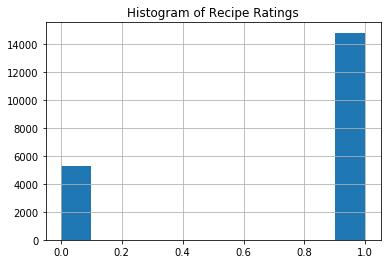

In [16]:
raw_data_01.rating.hist()
plt.title('Histogram of Recipe Ratings')
plt.show()

In [17]:
Y = raw_data_01.rating
X = raw_data_01[features]

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 16041
The number of observations in test set is 4011


In [19]:
svc = SVC().fit(X_train, y_train)

In [20]:
# making predictions
y_preds_test = svc.predict(X_test)

# evaluate 
print("R-squared of the model on the test set is: {}".format(svc.score(X_test, y_test)))

R-squared of the model on the test set is: 1.0


In [21]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_preds_test, target_names = ['class 0', 'class 1']))

              precision    recall  f1-score   support

     class 0       1.00      1.00      1.00      1068
     class 1       1.00      1.00      1.00      2943

    accuracy                           1.00      4011
   macro avg       1.00      1.00      1.00      4011
weighted avg       1.00      1.00      1.00      4011



## Selection Method 2: SelectKBest

In [22]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
X_new = SelectKBest(f_regression, k=30).fit_transform(raw_data.drop(['rating', 'title'], axis=1), raw_data.rating)
X_new

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [23]:
X_new.shape

(20052, 30)

In [24]:
feature_selector = SelectKBest(f_regression, k=30) 
X_new = feature_selector.fit_transform(raw_data.drop(['rating', 'title'], axis=1), raw_data.rating) 
X_new.shape 
raw_data.drop(['rating', 'title'], axis=1).columns[feature_selector.get_support()]

Index(['alcoholic', 'bake', 'bitters', 'bon appétit', 'brandy', 'chartreuse',
       'cocktail', 'cocktail party', 'condiment', 'créme de cacao', 'dinner',
       'drink', 'fall', 'fortified wine', 'gin', 'harpercollins',
       'house & garden', 'kosher', 'lime juice', 'liqueur', 'non-alcoholic',
       'peanut free', 'pernod', 'roast', 'rum', 'sauté', 'soy free', 'spirit',
       'tree nut free', 'weelicious'],
      dtype='object')

In [25]:
# compile features

features = ['alcoholic', 'bake', 'bitters', 'bon appétit', 'brandy', 'chartreuse',
       'cocktail', 'cocktail party', 'condiment', 'créme de cacao', 'dinner',
       'drink', 'fall', 'fortified wine', 'gin', 'harpercollins',
       'house & garden', 'kosher', 'lime juice', 'liqueur', 'non-alcoholic',
       'peanut free', 'pernod', 'roast', 'rum', 'sauté', 'soy free', 'spirit',
       'tree nut free', 'weelicious']

In [26]:
raw_data_01 = raw_data.copy()

In [27]:
# convert scores to binary (median cutoff)

for index, row in raw_data_01.iterrows():
    if row['rating'] > raw_data_01.rating.median():
        raw_data_01.loc[index, 'rating'] = 1
    else:
        raw_data_01.loc[index, 'rating'] = 0

In [28]:
Y = raw_data_01.rating
X = raw_data_01[features]

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 16041
The number of observations in test set is 4011


In [30]:
svc = SVC()
svc.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [31]:
# making predictions
y_preds_test = svc.predict(X_test)

# evaluate 
print("Accuracy of the model on the test set is: {}".format(svc.score(X_test, y_test)))

Accuracy of the model on the test set is: 0.7456993268511594
